# Lab 5: Regression and Dimensionality Reduction

NAME: Xinyi Li

STUDENTID: 21147426

## Task1

In [140]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.decomposition import FactorAnalysis as FA

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## EDA

We start with a brief EDA to check for missing values and outliers.

In [141]:
df = pd.read_csv("./insurance.csv")
df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In [142]:
df.tail()

,age,gender,bmi,children,smoker,region,insurance_cost
1333,64,female,31.825,2,no,northeast,16069.08475
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790
1336,64,male,36.960,2,yes,southeast,49577.66240
1337,64,male,23.760,0,yes,southeast,26926.51440


Let's examine values in the categorical column `Species` first.

In [143]:
df['gender'].value_counts()

male      676
female    662
Name: gender, dtype: int64

In [144]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [145]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

Now, let's check for missing values and outliers.

In [146]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

There are no obvious missing values. Let's also examine the basic statistics of the numerical attributes.

In [147]:
df.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


They all look OK.

In [148]:
df[df.children == 0]

,age,gender,bmi,children,smoker,region,insurance_cost
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
4,18,female,35.625,0,no,northeast,2211.13075
6,18,female,30.115,0,no,northeast,21344.84670
7,18,male,23.750,0,no,northeast,1705.62450
...,...,...,...,...,...,...,...
1331,64,female,39.700,0,no,southwest,14319.03100
1332,64,female,35.970,0,no,southeast,14313.84630
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790


Next, let's check for outliers in the numerical columns. Based on the table above we can try to plot all numerical column .

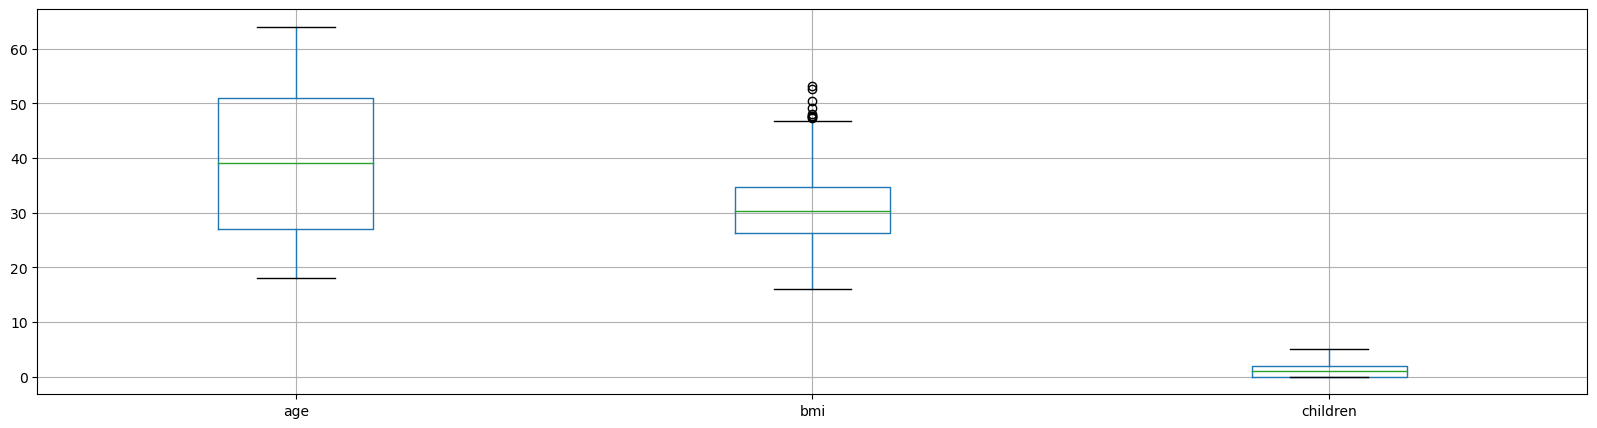

In [149]:
df.drop('insurance_cost', axis=1).boxplot(figsize=(20,5))
plt.show()

There are some outliers with the default settings for the boxplot function but they do not look like they need special treatement. 

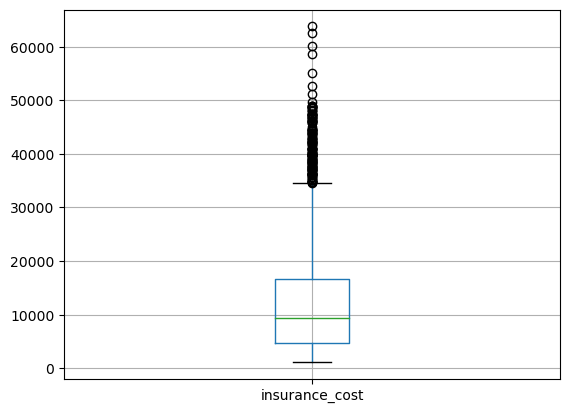

In [150]:
df.boxplot(column=['insurance_cost'])
plt.show()

## Data Preparation

In [151]:
#df = df.drop(df[df.Weight == 0].index)

In [152]:
df = pd.get_dummies(df, columns=['region','smoker','gender'], 
                        #dummy_na=True, 
                        drop_first=True)

In [153]:
df.head()

,age,bmi,children,insurance_cost,region_northwest,region_southeast,region_southwest,smoker_yes,gender_male
0,18,33.770,1,1725.55230,0,1,0,0,1
1,18,34.100,0,1137.01100,0,1,0,0,1
2,18,26.315,0,2198.18985,0,0,0,0,0
3,18,38.665,2,3393.35635,0,0,0,0,0
4,18,35.625,0,2211.13075,0,0,0,0,0


In [154]:
df.tail()

,age,bmi,children,insurance_cost,region_northwest,region_southeast,region_southwest,smoker_yes,gender_male
1333,64,31.825,2,16069.08475,0,0,0,0,0
1334,64,26.885,0,29330.98315,1,0,0,1,0
1335,64,26.410,0,14394.55790,0,0,0,0,1
1336,64,36.960,2,49577.66240,0,1,0,1,1
1337,64,23.760,0,26926.51440,0,1,0,1,1


Since there are no obvious outliers, we will apply `StandardScaler` to all predictor columns witha very simple (compared to example A) pre-rpocessing pipeline.

In [155]:
preprocess_pipeline = make_pipeline(StandardScaler())

Now we can separate the columns into *target* and *predictors* and split the dataset into a training and test sets. 

In [156]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Task2

### Grid Search for Best Parameters and Best Dimensionality Reduction Method

Next, we train `RandomForestRegressor` on the training set with a range of possible parameters in order to find the best parameters by cross-validation. To do this we will build another [main] pipeline which includes the preprocessing pipeline and `RandomForestRegressor`. We also add an element for dimensionality reduction after the preprocessing pipeline.

Here we will attempt three different dimensionality reduction methods and we will let the grid search pick the best one. These are:

- Principal Component Analysis (PCA)
- Recursive Feature Elimination (RFE) with estimator `svm.SVR`
- Recursive Feature Elimination (RFE) with estimator `LinearRegression`

Note that RFE is using regression algorithms for selecting the best features. These regression algorithms can be different from the regression algorithm at the end of the main pipeline.

The main pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation. It also applies the dimensionality reduction method separately to the two sets.

### Random Forest Pipeline

The pipeline contains a placeholder for the dimensionality reduction method. We will treat the method as a parameter and let the grid search pick the best of the three methods.

In [157]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

We limit the parameter grid to a few options for the `max_depth` parameter of `RandomForestRegressor` and to three alternative values for the number of selected features by the dimensionality reduction method. More parameters and values can be explored. Here we limit the options to make sure the grid search does not take too long to execute.

In [158]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.856:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'regresson__max_depth': 4}


The parameter `refit=True` makes the `GridSearchCV` train a `RandomForestRegressor` model on the **whole training set** with the best parameters and the best dimensionality reduction method found. This best model can then be accessed via the `.best_estimator_` attribute of the `GridSearchCV`.

Let's repeat the same experiment but with `LinearRegression` for training a regression model.

### Linear Regression Pipeline

In [159]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

Again we limit the parameter grid to one parameter of `LinearRegression` and three alternative values for the number of selected features to make sure the grid search does not take too long to execute.

In [160]:
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.747:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__normalize': False}


The results suggest that Random Forest performs better. The cross-validation score is `1 - relative squared error`. The higher the score the more accurate the model. We can now further confirm this by comparing the best models on the test set.

## Compare Regression Models on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

- mean squared error (MSE)
- mean absolute error (MAE)
- 1-relative squared error (R2)

to choose the better regressor for our problem.

In [161]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

We will use the function above to evaluate the best Random Forest and Linear Regression models found by the grid search.

In [162]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)

We will use a Pandas bar plots to compare the results. 

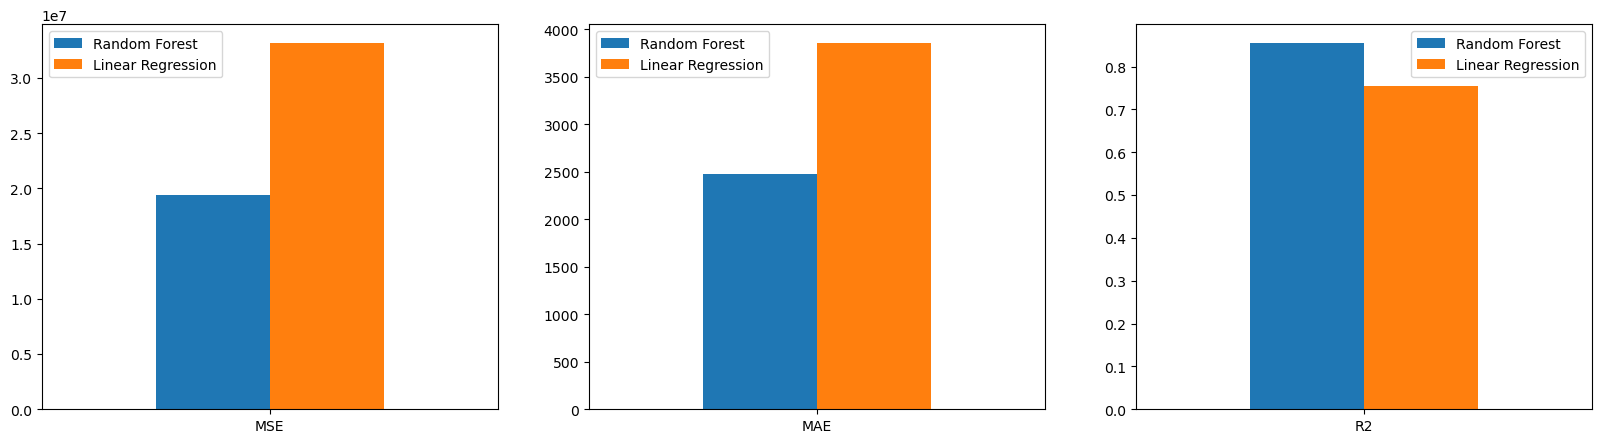

In [163]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

This tests confirms that Random Forest is the better regression model with lower MSE and MAE and higher R2.

In [164]:
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=5)
model = DecisionTreeRegressor()
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('Decision Tree Regressor',rfe),
                       ('m',model)])

In [165]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [166]:
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [167]:
DTR_mse, DTR_mae, DTR_r2 = evaluate_model(X_test, y_test, LR_best_model)

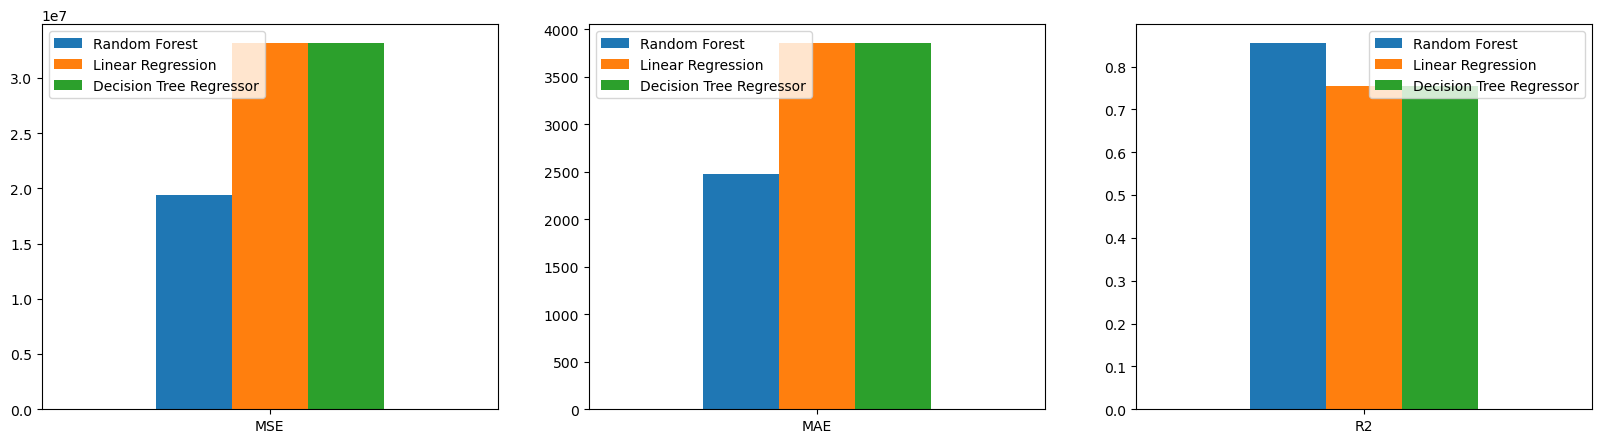

In [168]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'Decision Tree Regressor': DTR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'Decision Tree Regressor': DTR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'Decision Tree Regressor': DTR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

Baed on the above results, Linear regression performed similarly to Decision tree regression. RF is better.
LR generally support on linear case and DTR suit on non-linear case.

## Task3

In [169]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

In [170]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [FA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.856:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__max_depth': 4}


In [171]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [172]:
import warnings
warnings.filterwarnings('ignore')
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [TSNE(n_components=2, learning_rate='auto', init='random')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.747:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__normalize': False}


In [173]:
Updated_RF_mse, Updated_RF_mae, Updated_RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
Updated_LR_mse, Updated_LR_mae, Updated_LR_r2 = evaluate_model(X_test, y_test, LR_best_model)

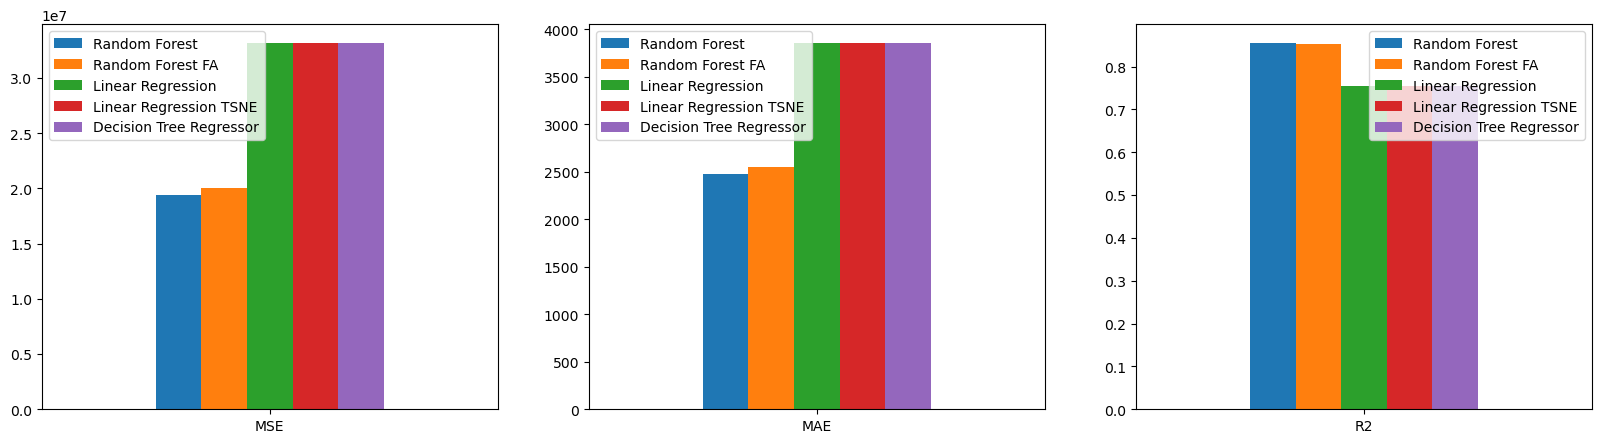

In [174]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Random Forest FA': Updated_RF_mse, 'Linear Regression': LR_mse, 'Linear Regression TSNE': Updated_LR_mse, 'Decision Tree Regressor': DTR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Random Forest FA': Updated_RF_mae, 'Linear Regression': LR_mae, 'Linear Regression TSNE': Updated_LR_mae, 'Decision Tree Regressor': DTR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2,'Random Forest FA': Updated_RF_r2, 'Linear Regression': LR_r2, 'Linear Regression TSNE': Updated_LR_r2, 'Decision Tree Regressor': DTR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

In [ ]:
For Task 3 of this lab i used Factor Analysis (FA) and t-distributed Stochastic Neighbor Embedding (TSNE).
In terms of the above results, we can see a an increase in the MSE & MAE for random forest when we use FA and a decrease in R2. so random forest did not benefit from FA in this case. 
We cannot see any changes on LR & LR with TSNE.

## Train a Final Model

Finally, we can train a Random Forest regression model with all the data we have, assuming that the more data we have the better the model.

In [175]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

We can also store this model on disk.

In [176]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))